In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from batch_process import BatchProcess, FedBatchProcess
from utils import *

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# # Define kinetic parameters
# mu_max = 0.870
# K_s = 0.214
# Y_xs = 0.496

# data = get_data(file_name='./data_processed.xlsx')
# exp = data.index.unique()

# for i in exp:
#     print(f'Working on experiment {i}')
#     # Perform data filtering using Savitzky-Golay filter
#     # df = filter_dataset(data.loc[i], 10, 3)
    
#     # # Plot raw data and filtered data
#     # plot_filter_vs_raw(df, title=i)
    
#     batch = BatchProcess(data.loc[i], mu_max, K_s, Y_xs)
#     batch.simulate(eval=False)
#     batch.plot_simulation(title=i)
#     break

__Parameter estimation using PINN__

In [30]:
import torch
from pinn import PINN, numpy_to_tensor

In [32]:
df = data.loc['BR04']
df = df[df['Process']=='B']

In [33]:
def system_ode(t, y):
    X, S = y
    mu = mu_max * S / (Ks + S)
    dXdt = mu * X
    dSdt = - mu * X / Yxs
    return [dXdt, dSdt]

def plot_simulation(t, y, full_df, train_df):
    plt.figure(figsize=(10, 3))
    plt.plot(t, y[0], label='X')
    plt.plot(t, y[1], label='S')
    plt.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose', color='red', alpha=0.2)   
    plt.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass', color='green', alpha=0.2)
    plt.scatter(train_df['RTime'], train_df['Glucose'], marker='x', label='Glucose', color='red')   
    plt.scatter(train_df['RTime'], train_df['Biomass'], marker='x', label='Biomass', color='green')
    plt.legend()
    plt.show()

Training using 8 data points
Epoch 0/10000 Loss: 29.036928176879883
mu_max: 0.4999 K_s: 0.5001 Y_xs: 0.5001
Epoch 10/10000 Loss: 28.677104949951172
mu_max: 0.4989 K_s: 0.5011 Y_xs: 0.5011
Epoch 20/10000 Loss: 28.324615478515625
mu_max: 0.4979 K_s: 0.5020 Y_xs: 0.5020
Epoch 30/10000 Loss: 27.980239868164062
mu_max: 0.4971 K_s: 0.5029 Y_xs: 0.5029
Epoch 40/10000 Loss: 27.64468765258789
mu_max: 0.4962 K_s: 0.5037 Y_xs: 0.5037
Epoch 50/10000 Loss: 27.31837272644043
mu_max: 0.4956 K_s: 0.5043 Y_xs: 0.5044
Epoch 60/10000 Loss: 27.001495361328125
mu_max: 0.4950 K_s: 0.5047 Y_xs: 0.5050
Epoch 70/10000 Loss: 26.694101333618164
mu_max: 0.4946 K_s: 0.5050 Y_xs: 0.5054
Epoch 80/10000 Loss: 26.39615821838379
mu_max: 0.4943 K_s: 0.5052 Y_xs: 0.5056
Epoch 90/10000 Loss: 26.107080459594727
mu_max: 0.4942 K_s: 0.5052 Y_xs: 0.5057
Epoch 100/10000 Loss: 25.826805114746094
mu_max: 0.4943 K_s: 0.5050 Y_xs: 0.5056
Epoch 110/10000 Loss: 25.555164337158203
mu_max: 0.4945 K_s: 0.5047 Y_xs: 0.5054
Epoch 120/100

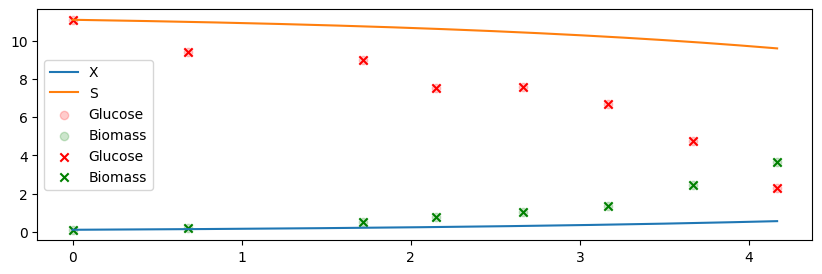

In [36]:
for i in range(8, len(df)+1):
    print(f'Training using {i} data points')
    _df = df.iloc[:i]
    t = numpy_to_tensor(_df['RTime'].values)
    X = numpy_to_tensor(_df['Biomass'].values)
    S = numpy_to_tensor(_df['Glucose'].values)
    X_S = torch.cat((X, S), 1)
    
    net = PINN(1, 2, t_start=t[0], t_end=t[-1])     
    net.fit(t, X_S, verbose=True)    
    
    # Print estimated parameters
    mu_max = net.mu_max.item()
    Ks = net.K_s.item()
    Yxs = net.Y_xs.item()
    
    print(f'mu_max: {mu_max:4f}, Ks: {Ks:4f}, Yxs: {Yxs:.4f}')
    t_eval = np.linspace(df['RTime'].min(), df['RTime'].max(), 1000)
    sol = solve_ivp(system_ode, y0=[df['Biomass'].iloc[0], df['Glucose'].iloc[0]], \
        t_span=[df['RTime'].min(), df['RTime'].max()], t_eval=t_eval)
    plot_simulation(sol.t, sol.y, full_df=df, train_df=_df)